In [1]:
from typing import Callable, Union

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
import matplotlib.pyplot as plt 

import random
from pathlib import Path
from PIL import Image

from operator import itemgetter

import sys
sys.path.append('../src')
from utils import class2one_hot

In [2]:
def make_dataset(root, subset) -> list[tuple[Path, Path]]:
    assert subset in ["train", "val", "test"]

    root = Path(root)

    img_path = root / subset / "img"
    full_path = root / subset / "gt"

    images = sorted(img_path.glob("*.png"))
    full_labels = sorted(full_path.glob("*.png"))

    return list(zip(images, full_labels))


class SliceDataset(Dataset):
    def __init__(
        self,
        subset,
        root_dir,
        img_transform=None,
        gt_transform=None,
        augment=False,
        normalize=False,
        debug=False,
    ):
        self.root_dir: str = root_dir
        self.img_transform: Callable = img_transform
        self.gt_transform: Callable = gt_transform
        self.augmentation: bool = augment
        self.normalize: bool = normalize

        self.files = make_dataset(root_dir, subset)
        if debug:
            self.files = self.files[:10]

        print(f">> Created {subset} dataset with {len(self)} images...")

    def __len__(self):
        return len(self.files)
    
    def apply_window(self, img: Tensor, window_center: float, window_width: float) -> Tensor:
        img_min = window_center - window_width / 2
        img_max = window_center + window_width / 2
        return torch.clamp(img, img_min, img_max)

    def histogram_equalization(self, img: Tensor) -> Tensor:
        # Convert to numpy for easier histogram manipulation
        img_np = img.cpu().numpy()
        
        # Calculate histogram
        hist, bin_edges = np.histogram(img_np, bins=256, range=(img_np.min(), img_np.max()))
        
        # Calculate cumulative distribution function (CDF)
        cdf = hist.cumsum()
        cdf_normalized = cdf * hist.max() / cdf.max()
        
        # Linear interpolation of CDF to map intensity values
        img_equalized = np.interp(img_np.flatten(), bin_edges[:-1], cdf_normalized)
        
        # Reshape back to original shape and convert to tensor
        img_equalized = torch.from_numpy(img_equalized.reshape(img_np.shape)).to(img.device)
        
        return img_equalized

    def normalize_mediastinal_window(self, img: Tensor) -> Tensor:
        # Mediastinal window parameters
        window_level = 40
        window_width = 350

        # Apply windowing
        # img = self.apply_window(img, window_level, window_width)

        # Apply histogram equalization
        equalized_img = self.histogram_equalization(img)

        # Normalize to [-1, 1] range
        normalized_img = 2 * (equalized_img - equalized_img.min()) / (equalized_img.max() - equalized_img.min()) - 1

        return normalized_img

    def __getitem__(self, index) -> dict[str, Union[Tensor, int, str]]:
        img_path, gt_path = self.files[index]

        img: Tensor = self.img_transform(Image.open(img_path))
        gt: Tensor = self.gt_transform(Image.open(gt_path))

        if self.normalize:
            img = self.normalize_mediastinal_window(img)

        if self.augmentation:
            # Apply augmentation if random is above trheshold
            if random.random() > 2 / 3:
                # Only apply one augmentation at a time
                random_val = random.random()

                if random_val < 0.1:
                    img = transforms.functional.vflip(img)
                    gt = transforms.functional.vflip(gt)

                if random_val < 0.3:
                    C = gt.size(-3)
                    angle = random.uniform(-5, 5)
                    img = TF.rotate(
                        img, angle, interpolation=TF.InterpolationMode.BILINEAR
                    )
                    class_indices = torch.argmax(gt, dim=-3)
                    rotated_class_indices = (
                        TF.rotate(
                            class_indices.unsqueeze(0).float(),
                            angle,
                            interpolation=TF.InterpolationMode.NEAREST,
                        )
                        .squeeze(0)
                        .long()
                    )
                    gt = torch.nn.functional.one_hot(
                        rotated_class_indices, num_classes=C
                    ).permute(-1, -3, -2)

                elif random_val < 0.8:
                    original_size = img.shape[-2:]

                    # Custom cropping implementation
                    crop_size = (int(img.size(-2) / 1.1), int(img.size(-1) / 1.1))
                    i = random.randint(0, img.size(-2) - crop_size[0])
                    j = random.randint(0, img.size(-1) - crop_size[1])
                    img = img[:, i : i + crop_size[0], j : j + crop_size[1]]
                    gt = gt[:, i : i + crop_size[0], j : j + crop_size[1]]

                    # Bilinear interpolation to resize back to original size
                    img = torch.as_tensor(
                        F.interpolate(
                            img.float().unsqueeze(0),
                            size=original_size,
                            mode="bilinear",
                            align_corners=False,
                        ).squeeze(0)
                    )
                    gt = torch.as_tensor(
                        F.interpolate(
                            gt.float().unsqueeze(0),
                            size=original_size,
                            mode="nearest",
                        ).squeeze(0)
                    ).long()

                else:
                    noise = torch.randn(img.size()) * 0.01
                    img = img + noise
                    img = torch.clamp(img, 0, 1)

        _, W, H = img.shape
        K, _, _ = gt.shape
        assert gt.shape == (K, W, H)

        return {"images": img, "gts": gt, "stems": img_path.stem, "original_image": self.img_transform(Image.open(img_path))}


In [5]:
root_dir = "../" / Path("data") / "SEGTHOR_MANUAL_SPLIT"

K = 5  # Number of classes

img_transform = transforms.Compose(
    [
        lambda img: img.convert("L"),  # convert to grayscale
        lambda img: np.array(img)[np.newaxis, ...],
        lambda nd: nd / 255,  # max <= 1 (range [0, 1])
        lambda nd: torch.tensor(nd, dtype=torch.float32),
    ]
)


gt_transform = transforms.Compose(
    [
        lambda img: np.array(img)[...],
        # The idea is that the classes are mapped to {0, 255} for binary cases
        # {0, 85, 170, 255} for 4 classes
        # {0, 51, 102, 153, 204, 255} for 6 classes
        # Very sketchy but that works here and that simplifies visualization
        lambda nd: nd / (255 / (K - 1)) if K != 5 else nd / 63,  # max <= 1
        lambda nd: torch.tensor(nd, dtype=torch.int64)[
            None, ...
        ],  # Add one dimension to simulate batch
        lambda t: class2one_hot(t, K=K),
        itemgetter(0),
    ]
)

train_set = SliceDataset(
    "train",
    root_dir,
    img_transform=img_transform,
    gt_transform=gt_transform,
    debug=False,
    augment=False,
    normalize=True,
)
train_loader = DataLoader(
    train_set, batch_size=5, num_workers=0, shuffle=True,
)

>> Created train dataset with 3097 images...


[0]
(256, 256)
(256, 256, 4)
[0]
(256, 256)
(256, 256, 4)
[0 1 4]
(256, 256)
(256, 256, 4)
[0 1 3 4]
(256, 256)
(256, 256, 4)
[0 1 3 4]
(256, 256)
(256, 256, 4)
[0 1 3]
(256, 256)
(256, 256, 4)
[0 1 3]
(256, 256)
(256, 256, 4)
[0 1 3]
(256, 256)
(256, 256, 4)
[0]
(256, 256)
(256, 256, 4)
[0 4]
(256, 256)
(256, 256, 4)
[0 4]
(256, 256)
(256, 256, 4)
[0 4]
(256, 256)
(256, 256, 4)
[0 4]
(256, 256)
(256, 256, 4)
[0 1 3]
(256, 256)
(256, 256, 4)
[0 1 2 4]
(256, 256)
(256, 256, 4)
[0 1 3 4]
(256, 256)
(256, 256, 4)
[0 1 3 4]
(256, 256)
(256, 256, 4)
[0 1 2 4]
(256, 256)
(256, 256, 4)
[0]
(256, 256)
(256, 256, 4)
[0]
(256, 256)
(256, 256, 4)
[0]
(256, 256)
(256, 256, 4)
[0 1 4]
(256, 256)
(256, 256, 4)
[0 1 3]
(256, 256)
(256, 256, 4)
[0 1 2 4]
(256, 256)
(256, 256, 4)
[0 1 4]
(256, 256)
(256, 256, 4)


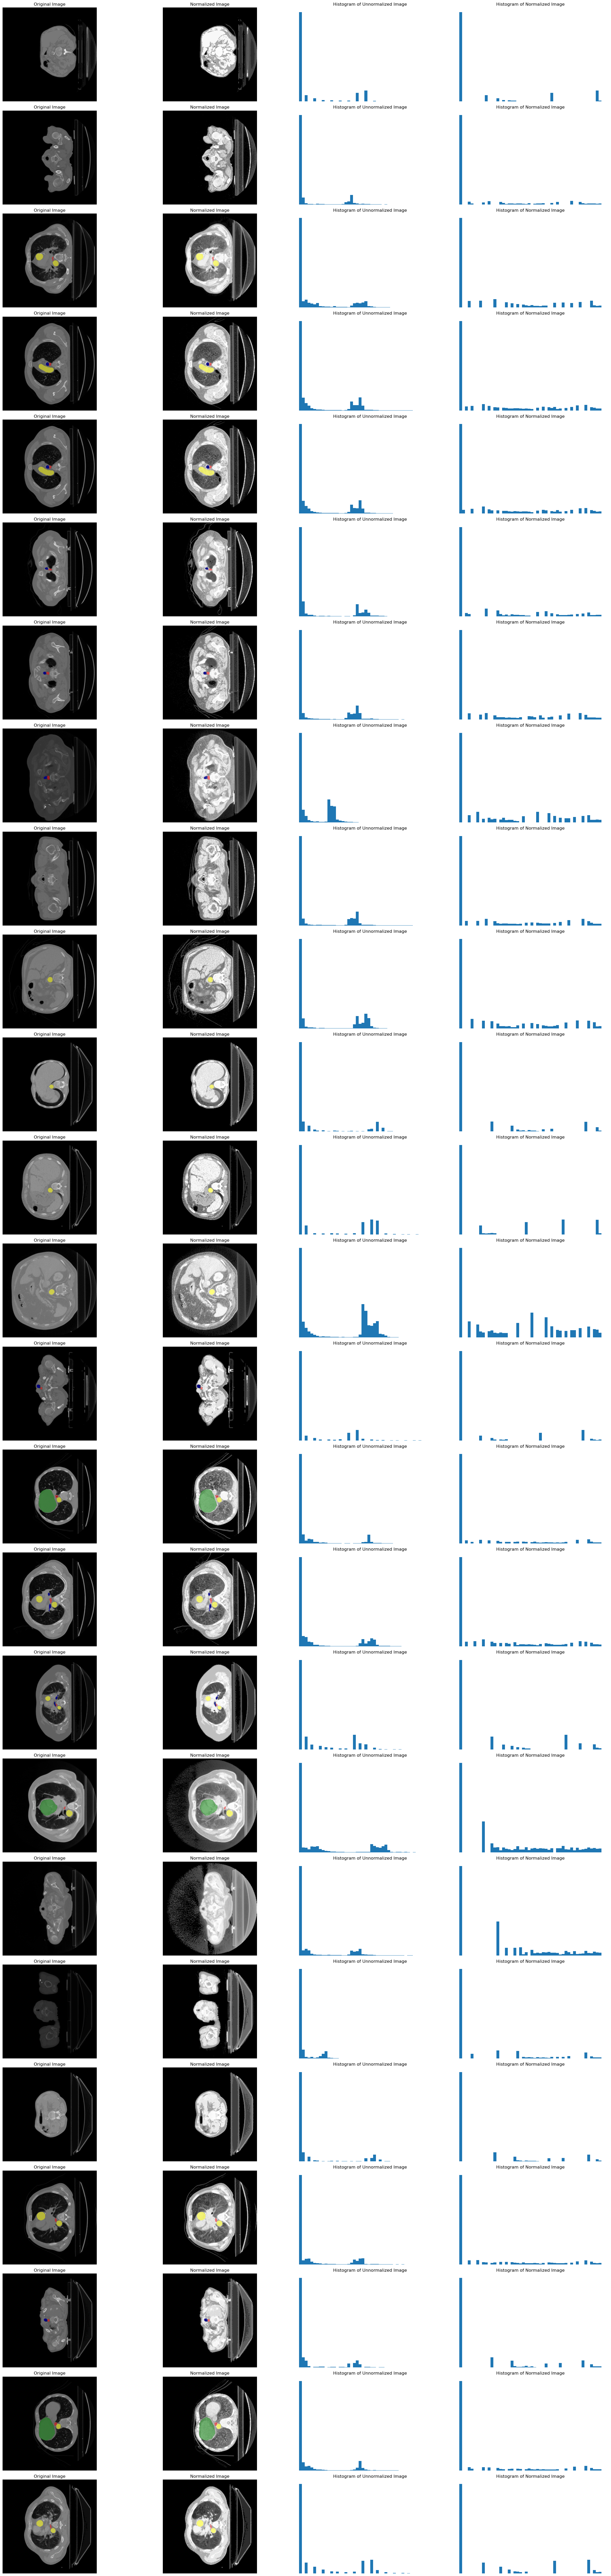

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.transforms import functional as TF
from PIL import Image

def visualize_batch_normalization(train_loader, N=25):
    fig, ax = plt.subplots(N, 4, figsize=(25, 4*N))
    
    if N == 1:
        ax = ax.reshape(1, -1)

    colors = ['red', 'green', 'blue', 'yellow']

    for idx, batch in enumerate(train_loader):
        if idx == N:
            break

        gt = batch["gts"][0].cpu().numpy()
        gt = np.argmax(gt, axis=0)
        print(np.unique(gt))
        gt_colored = np.zeros((*gt.shape, 4))

        color_labels = [0, 1, 2, 3, 4]
        for class_idx, color in enumerate(colors, start=1):
            mask = gt == color_labels[class_idx]
            rgba_color = plt.cm.colors.to_rgba(color, alpha=0.5)
            gt_colored[mask] = rgba_color

        # Original image (before normalization)
        original_img = batch["original_image"][0].squeeze().cpu().numpy()
        print(original_img.shape)
        print(gt_colored.shape)
        ax[idx, 0].imshow(original_img, cmap="gray")
        ax[idx, 0].imshow(gt_colored)
        ax[idx, 0].set_title("Original Image")

        # Normalized image
        normalized_img = batch["images"][0].squeeze().cpu().numpy()
        ax[idx, 1].imshow(normalized_img, cmap="gray")
        ax[idx, 1].imshow(gt_colored)
        ax[idx, 1].set_title("Normalized Image")

        # Ground truth segmentation
        # K = batch["gts"].shape[1]  # Number of classes
        # color_map = plt.get_cmap("viridis", K)
        # gt_colored = color_map(batch["gts"][0].argmax(dim=0).cpu().numpy())
        # ax[idx, 2].imshow(gt_colored)
        # ax[idx, 2].set_title("Ground Truth")

        # Histogram of unnormalized image
        ax[idx, 2].hist(original_img.ravel(), bins=50)
        ax[idx, 2].set_title("Histogram of Unnormalized Image")
        ax[idx, 2].set_xlabel("Pixel Intensity")
        ax[idx, 2].set_ylabel("Frequency")

        # Histogram of normalized image
        ax[idx, 3].hist(normalized_img.ravel(), bins=50)
        ax[idx, 3].set_title("Histogram of Normalized Image")
        ax[idx, 3].set_xlabel("Pixel Intensity")
        ax[idx, 3].set_ylabel("Frequency")

        for i in range(4):
            if i != 4:  # Keep axes for the histogram
                ax[idx, i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_batch_normalization(train_loader, N=25)

# Usage example:
# dataset = SliceDataset(subset="train", root_dir="path/to/data", normalize=True)
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
# visualize_batch_normalization(train_loader, dataset, N=5)